In [72]:
import   cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


### Question 1 Counting objects

### Use of Canny

In [73]:
## Sample images  in Data directory
def count_objects(image_path):
    # Load the image using opencv
    image = cv2.imread(image_path)
    # Convert the image to grayscale for easy manipulation
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise and help contour detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    
    # Use Canny edge detection we could also use sobel
    edges = cv2.Canny(blurred, 50, 100)
    
    # Find contours in the edges, this can help to detect the edges 
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Count the number of objects which should just be the number of contours you have i
    # return the number of objects
    return len(contours)

In [74]:
count_objects("q1_data/1b.png")

13

#### Use of Sobel

In [75]:
def count_objects(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found!")
        return 0

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and help with contour detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Use Sobel edge detection in both x and y directions
    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)  
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)  

    # Combine both Sobel filters to get the final edge map
    sobel_edges = cv2.magnitude(sobel_x, sobel_y)

    # Convert back to 8-bit grayscale (Sobel output is float64)
    sobel_edges = np.uint8(sobel_edges)

    # Apply thresholding to make edges more distinct
    _, binary_edges = cv2.threshold(sobel_edges, 88, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(binary_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Return the number of detected objects
    return len(contours)

In [76]:
image_path = "q1_data/1b.png" 
object_count = count_objects(image_path)
print(f"Number of objects detected: {object_count}")

Number of objects detected: 14


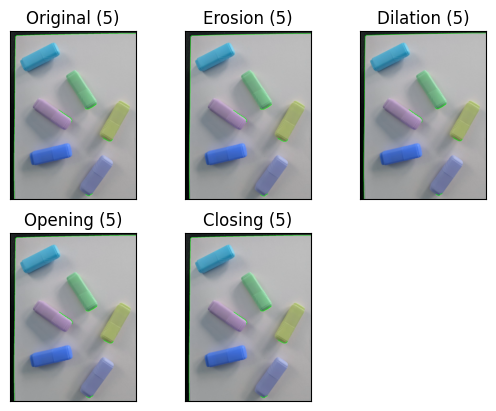

Original: 5 objects detected
Erosion: 5 objects detected
Dilation: 5 objects detected
Opening: 5 objects detected
Closing: 5 objects detected


In [77]:
def count_objects(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Define a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)

    # Apply different morphological operations
    operations = {
        "Original": blurred,
        "Erosion": cv2.erode(blurred, kernel, iterations=1),
        "Dilation": cv2.dilate(blurred, kernel, iterations=1),
        "Opening": cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel),
        "Closing": cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel),
    }

    object_counts = {}

    for op_name, processed_img in operations.items():
        # Use Canny edge detection
        edges = cv2.Canny(processed_img, 50, 100)

        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Store the count of objects detected
        object_counts[op_name] = len(contours)

        # Draw contours on the original image
        output_img = image.copy()
        cv2.drawContours(output_img, contours, -1, (0, 255, 0), 2)

        # Display the processed images
        plt.subplot(2, 3, list(operations.keys()).index(op_name) + 1)
        plt.imshow(output_img, cmap='gray')
        plt.title(f"{op_name} ({len(contours)})")
        plt.xticks([]), plt.yticks([])

    plt.show()

    return object_counts


# Test the function
image_path = "count.jpg"  # Change this to your image
object_counts = count_objects(image_path)

# Print object counts for each operation
for operation, count in object_counts.items():
    print(f"{operation}: {count} objects detected")


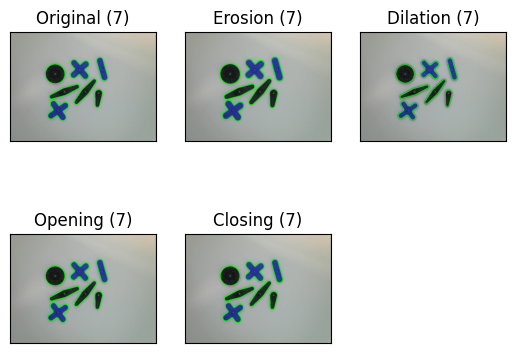

{'Original': 7, 'Erosion': 7, 'Dilation': 7, 'Opening': 7, 'Closing': 7}

In [78]:
count_objects('q1_data/1a.png')

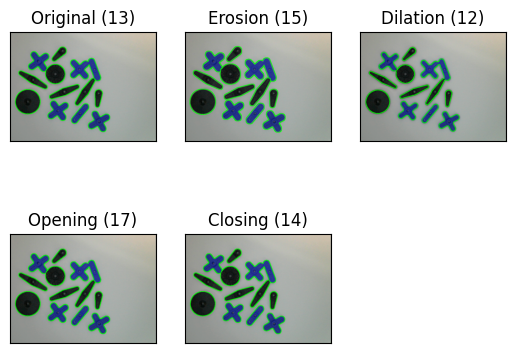

{'Original': 13, 'Erosion': 15, 'Dilation': 12, 'Opening': 17, 'Closing': 14}

In [79]:
count_objects('q1_data/1b.png')

- The naive method counted objects of image 2 to be 10 objects couold not distinguish between different along the boundaries.

### Question 2 Image Straightening 

In [97]:

def find_lines(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
  
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

     # Preprocessing Steps
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast Enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Apply Canny Edge Detection
    edges = cv2.Canny(enhanced, 50, 150)

    # Optional: Apply Morphological Operations (Dilation + Erosion) to enhance edges
     # Apply Morphological Operations (Dilation + Erosion)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    # Apply Hough Transform to detect lines
     # This returns an array of r and theta values
    lines = cv2.HoughLines(eroded, 1, np.pi / 180, threshold=450)

    # The below for loop runs till r and theta values
    # are in the range of the 2d array
    # Dictionary to store angles and their count
    angles_count = {}

    if lines is not None:
        for r_theta in lines:
            arr = np.array(r_theta[0], dtype=np.float64)
            r, theta = arr

            # Convert Polar Coordinates to Cartesian Coordinates
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * r
            y0 = b * r

            # Store the angles in a dictionary to count occurrences
            #Store the angles in a dictionary to count the number of lines corresponding to that angle
            if theta in angles_count.keys():
                angles_count[theta] += 1
            else:
                angles_count[theta] = 1

            # Compute endpoints of the detected line
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            # Draw the detected lines on the image
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Save the output image with detected lines
    cv2.imwrite('linesDetected.jpg', img)

    # Return the dictionary of angles
    return angles_count

# # Run the function and get the top 3 angles
angles_count = find_lines('q2_data/2c.jpg')
top_3_angles = sorted(angles_count, key=angles_count.get, reverse=True)[:3]

# Load and display the output image
img = cv2.imread('linesDetected.jpg')

In [98]:
# convert top angle go degrees for rotation
angle = top_3_angles[0]*180/np.pi

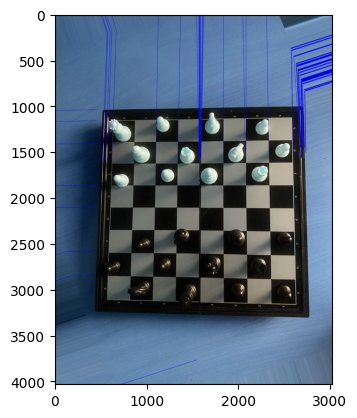

In [99]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated
rot_img = rotate_image(img, angle)
#show rot_img
plt.imshow(rot_img,cmap='gray')

#### REAL WORLD

In [102]:

def find_lines(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
  
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

     # Preprocessing Steps
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast Enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Apply Canny Edge Detection
    edges = cv2.Canny(enhanced, 50, 150)

    # Optional: Apply Morphological Operations (Dilation + Erosion) to enhance edges
     # Apply Morphological Operations (Dilation + Erosion)
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)

    # Apply Hough Transform to detect lines
     # This returns an array of r and theta values
    lines = cv2.HoughLines(eroded, 1, np.pi / 180, threshold=200)

    # The below for loop runs till r and theta values
    # are in the range of the 2d array
    # Dictionary to store angles and their count
    angles_count = {}

    if lines is not None:
        for r_theta in lines:
            arr = np.array(r_theta[0], dtype=np.float64)
            r, theta = arr

            # Convert Polar Coordinates to Cartesian Coordinates
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * r
            y0 = b * r

            # Store the angles in a dictionary to count occurrences
            #Store the angles in a dictionary to count the number of lines corresponding to that angle
            if theta in angles_count.keys():
                angles_count[theta] += 1
            else:
                angles_count[theta] = 1

            # Compute endpoints of the detected line
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            # Draw the detected lines on the image
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Save the output image with detected lines
    cv2.imwrite('linesDetectedTEST.jpg', img)

    # Return the dictionary of angles
    return angles_count

# # Run the function and get the top 3 angles
angles_count = find_lines('q2_data/2c.jpg')
top_3_angles = sorted(angles_count, key=angles_count.get, reverse=True)[:3]

# Load and display the output image
img = cv2.imread('linesDetectedTEST.jpg')

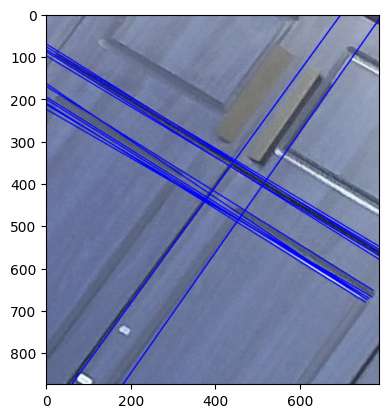

In [103]:
# Run the function and get the top 3 angles
angles_count = find_lines('lines3.jpg')
top_3_angles = sorted(angles_count, key=angles_count.get, reverse=True)[:3]

# Load and display the output image
img = cv2.imread('linesDetectedTEST.jpg')
plt.imshow(img)

In [104]:
# convert top angle go degrees for rotation
angle = top_3_angles[0]*180/np.pi

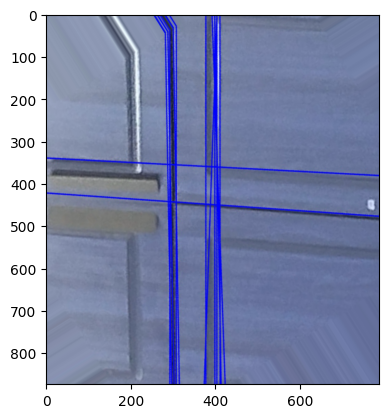

In [105]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated
rot_img = rotate_image(img, angle)
#show rot_img
plt.imshow(rot_img,cmap='gray')

### Question 3 Image compression

Compression Ratio: 0.01
Original Size: 9866.90 KB
Compressed Size: 1120.05 KB
Compression Achieved: 88.65%
----------------------------------------
Compression Ratio: 0.82
Original Size: 9866.90 KB
Compressed Size: 2932.91 KB
Compression Achieved: 70.28%
----------------------------------------
Compression Ratio: 0.0003
Original Size: 9866.90 KB
Compressed Size: 597.71 KB
Compression Achieved: 93.94%
----------------------------------------
Compression Ratio: 0.654
Original Size: 9866.90 KB
Compressed Size: 2891.28 KB
Compression Achieved: 70.70%
----------------------------------------
Compression Ratio: 0.9995
Original Size: 9866.90 KB
Compressed Size: 2959.05 KB
Compression Achieved: 70.01%
----------------------------------------


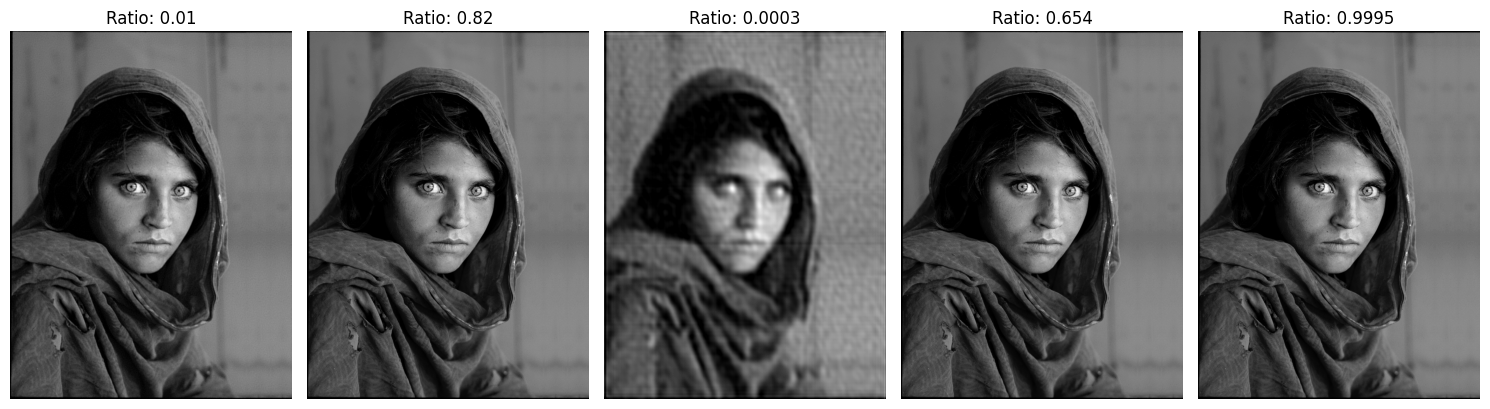

In [106]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def compress_image(image_path, compress_ratio):
    # Load image using OpenCV in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Image not found!")
        return None

    # Get the original file size
    original_size = os.path.getsize(image_path)

    # Compute the Fourier Transform
    f_transform = np.fft.fft2(img)
    f_transform_shifted = np.fft.fftshift(f_transform) 

    # Flatten and sort absolute frequencies
    f_sorted = np.sort(np.abs(f_transform_shifted).flatten())

    # Determine the threshold for filtering
    thresh = f_sorted[int(np.floor((1 - compress_ratio) * len(f_sorted)))]

    # Create a mask for filtering
    mask = np.abs(f_transform_shifted) > thresh
    filtered_fft = f_transform_shifted * mask

    # Apply inverse FFT to reconstruct image
    inverse_shifted = np.fft.ifftshift(filtered_fft)
    compressed_img = np.fft.ifft2(inverse_shifted).real  

    # Convert to uint8 for visualization
    compressed_img = np.uint8(np.clip(compressed_img, 0, 255))

    # Save temporarily to check compressed size
    temp_path = "compressed_temp.jpg"
    cv2.imwrite(temp_path, compressed_img)

    # compressed file size in bytes
    compressed_size = os.path.getsize(temp_path)  

    # compression details
    print(f"Compression Ratio: {compress_ratio}")
    print(f"Original Size: {original_size / 1024:.2f} KB")
    print(f"Compressed Size: {compressed_size / 1024:.2f} KB")
    print(f"Compression Achieved: {100 * (1 - (compressed_size / original_size)):.2f}%")
    print("-" * 40)

    return compressed_img


# List of compression ratios to try
compression_ratios = [0.01, 0.82, 0.0003, 0.654, 0.9995]

# Creating subplots
num_ratios = len(compression_ratios)
fig, axes = plt.subplots(1, num_ratios, figsize=(15, 5))

# Apply compression for each ratio and display
for i, ratio in enumerate(compression_ratios):
    compressed = compress_image("q3_data/q3a.jpg", compress_ratio=ratio)  
    axes[i].imshow(compressed, cmap='gray') 
    axes[i].set_title(f"Ratio: {ratio}")  
    axes[i].axis('off') 

plt.tight_layout()  
plt.show()  

#### Low frequency image

Compression Ratio: 0.031
Original Size: 194.89 KB
Compressed Size: 134.73 KB
Compression Achieved: 30.87%
----------------------------------------
Compression Ratio: 0.82
Original Size: 194.89 KB
Compressed Size: 204.65 KB
Compression Achieved: -5.01%
----------------------------------------
Compression Ratio: 0.0003
Original Size: 194.89 KB
Compressed Size: 35.18 KB
Compression Achieved: 81.95%
----------------------------------------
Compression Ratio: 0.654
Original Size: 194.89 KB
Compressed Size: 204.34 KB
Compression Achieved: -4.85%
----------------------------------------
Compression Ratio: 0.9995
Original Size: 194.89 KB
Compressed Size: 204.73 KB
Compression Achieved: -5.05%
----------------------------------------


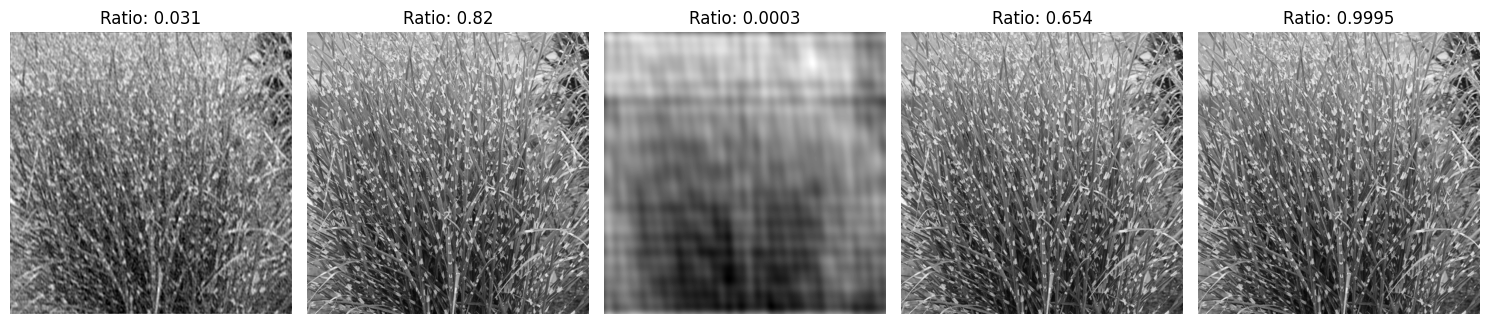

In [87]:
# List of compression ratios to try
compression_ratios = [0.031, 0.82, 0.0003, 0.654, 0.9995]

# Number of subplots
num_ratios = len(compression_ratios)

# Create subplots
fig, axes = plt.subplots(1, num_ratios, figsize=(15, 5))

# Apply compression for each ratio and display
for i, ratio in enumerate(compression_ratios):
    compressed = compress_image("q3_data/q3b.jpg", compress_ratio=ratio)
    axes[i].imshow(compressed, cmap='gray') 
    axes[i].set_title(f"Ratio: {ratio}")
    axes[i].axis('off')  

plt.tight_layout()  
plt.show()  

#### High resolution image

Compression Ratio: 1e-05
Original Size: 2301.19 KB
Compressed Size: 892.32 KB
Compression Achieved: 61.22%
----------------------------------------
Compression Ratio: 0.0001
Original Size: 2301.19 KB
Compressed Size: 1017.91 KB
Compression Achieved: 55.77%
----------------------------------------
Compression Ratio: 0.001
Original Size: 2301.19 KB
Compressed Size: 1227.24 KB
Compression Achieved: 46.67%
----------------------------------------
Compression Ratio: 0.01
Original Size: 2301.19 KB
Compressed Size: 2002.05 KB
Compression Achieved: 13.00%
----------------------------------------
Compression Ratio: 1
Original Size: 2301.19 KB
Compressed Size: 3395.47 KB
Compression Achieved: -47.55%
----------------------------------------


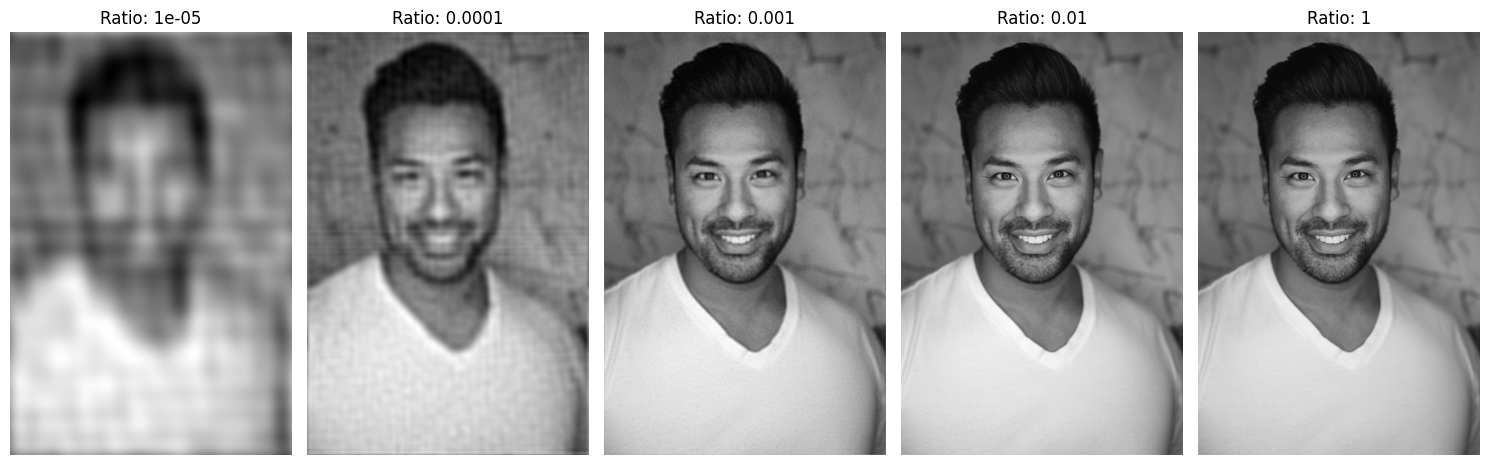

In [88]:
# List of compression ratios to try
compression_ratios = [0.00001, 0.0001, 0.001, 0.01, 1]

# Number of subplots
num_ratios = len(compression_ratios)

# Create subplots
fig, axes = plt.subplots(1, num_ratios, figsize=(15, 5))

# Apply compression for each ratio and display
for i, ratio in enumerate(compression_ratios):
    compressed = compress_image("people.jpg", compress_ratio=ratio)  # Apply compression
    axes[i].imshow(compressed, cmap='gray')  # Show compressed image
    axes[i].set_title(f"Ratio: {ratio}")  # Add title with compression ratio
    axes[i].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Display all subplots


### Question 4 Data Augmentation

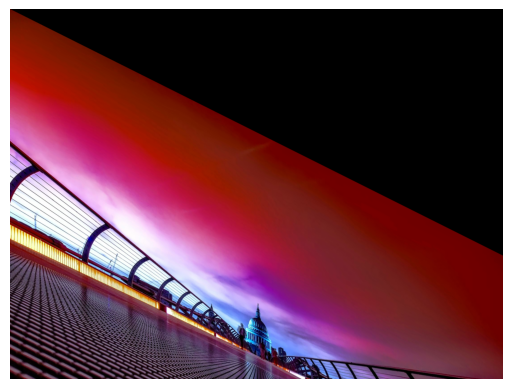

In [89]:
## Use your own images to test.  
def data_augmentation(img, type):
    if type == "resize1":
        # resize the  image to 224 x 224 use nearest neighbor used nearest neighbor interpolation
        augmented_img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)

    elif type == "resize2":
        # # resize the  image to 224 x 224 use cubic spline interpolation
        augmented_img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

    elif type == "vertical_flip":
        # Flip image vertically
        augmented_img = cv2.flip(img, 0)

    elif type == "horizontal_flip":
        # Flip image horizontally
        augmented_img = cv2.flip(img, 1)

    elif type == "blur_noise":
        # Apply Gaussian blur to add noise effect
        augmented_img = cv2.GaussianBlur(img, (5, 5), 0)

    elif type == "rotation":
        # Rotate by 30 degrees around the center
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), 30, 1)
        augmented_img = cv2.warpAffine(img, M, (w, h))

    elif type == "shear on y-axis":
        # shear transformation on y-axis
        M = np.float32([[1, 0, 0], [0.5, 1, 0]])
        h, w = img.shape[:2]
        augmented_img = cv2.warpAffine(img, M, (w, h))

    elif type == "shear on x-axis":
        # shear transformation on x-axis
        M = np.float32([[1, 0.5, 0], [0, 1, 0]])
        h, w = img.shape[:2]
        augmented_img = cv2.warpAffine(img, M, (w, h))

        # New transformations {Brightness}
    elif type == "brightness":
        # Increase brightness
        factor = 0.5  
        augmented_img = cv2.convertScaleAbs(img, alpha=factor, beta=0)

        # Contrast
    elif type == "contrast":
        # Increase contrast
        alpha = 7.3  # Increase contrast
        beta = 0  
        augmented_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)


    else:
        print("Error: Unknown augmentation type")
        return None

    return augmented_img

# Load an image
img = cv2.imread("trial.jpg")

# Apply augmentation
augmented_img = data_augmentation(img, "shear on y-axis")

plt.imshow(augmented_img, cmap='gray')  
plt.axis('off')  #
plt.show()  

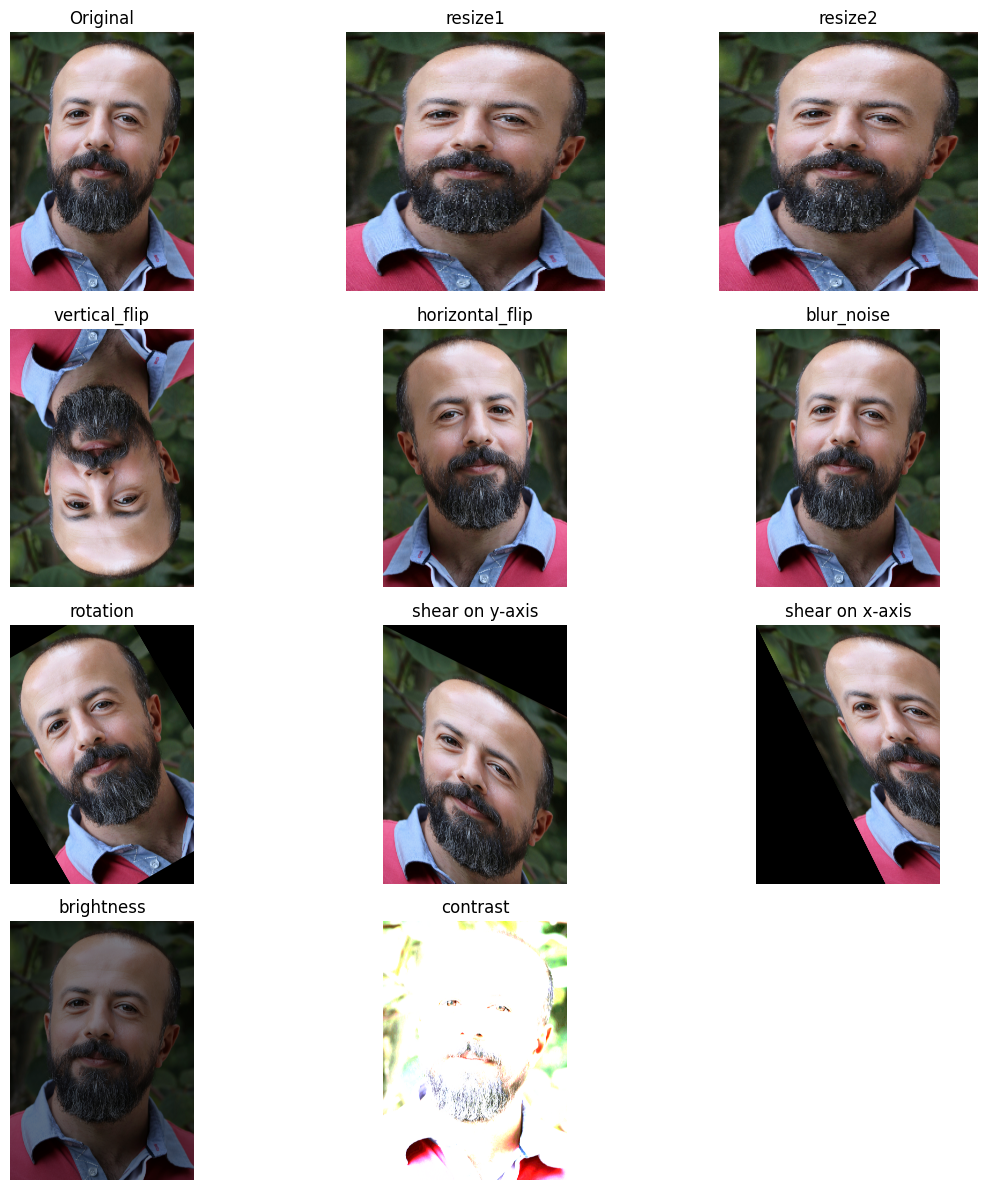

In [90]:
# Load an image
img = cv2.imread("Face.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply all augmentations
augmentations = ["resize1", "resize2", "vertical_flip", "horizontal_flip", "blur_noise", "rotation", "shear on y-axis", "shear on x-axis", "brightness", "contrast"]
augmented_images = {aug: data_augmentation(img, aug) for aug in augmentations}

# Plot original and augmented images
plt.figure(figsize=(12, 12))  
plt.subplot(4, 3, 1)  
plt.imshow(img)
plt.title("Original")
plt.axis("off")

for i, (key, aug_img) in enumerate(augmented_images.items(), 2):
    plt.subplot(4, 3, i)
    plt.imshow(aug_img)
    plt.title(key)
    plt.axis("off")

plt.tight_layout()
plt.show()